### Importing libraries

In [2]:
import torchvision.datasets as datasets
from bit_config import *
from utils import *
from visualize import *
import torch
import torchvision.transforms as transforms
from torchsummary import summary

import seaborn as sns
import pandas as pd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os, time

def same_output(model, org_model, eps=1e-8):
    x = simulate_input()
    return torch.allclose(model(x), org_model(x), atol=eps)

org_model = resmlp_24(pretrained=True).eval()
model = resmlp_24(pretrained=True)
qmodel = q_resmlp24(model, full_precision_flag=True)


### Tensor shape test

In [ ]:
T1 = torch.tensor([[1, 2, 3],
                [4, 5, 6],
                [7, 8, 9]])

torch.abs(T1).max(axis = 0)[0]   

In [254]:
n2 = get_linear_layers(model.blocks[0])[4][1]
fc1 = get_linear_layers(model.blocks[0])[5][1]
print(n2.weight.shape, n2.bias.shape)
print(fc1.weight.shape, fc1.bias.shape)
print(n2.weight.data.matmul(n2.bias).shape)


torch.Size([1536, 384]) torch.Size([1536])
torch.Size([384, 1536]) torch.Size([384])


RuntimeError: size mismatch, got 1536, 1536x384,1536

### Weight/Bias Modification Test

#### CLE

In [3]:
# def cross_layer_equalization(linear_layers):
#     S_history = dict()
#     eps = 1e-8
#     converged = [False] * (len(linear_layers)-1)
#     with torch.no_grad(): 
#         while not np.all(converged):
#             for idx in range(1, len(linear_layers)):
#                 (prev_name, prev), (curr_name, curr) = linear_layers[idx-1], linear_layers[idx]
                
#                 range_1 = 2.*torch.abs(prev.weight).max(axis = 1)[0] # abs max of each row * 2
#                 range_2 = 2.*torch.abs(curr.weight).max(axis = 0)[0] # abs max of each col * 2
#                 S = torch.sqrt(range_1 * range_2) / range_2

#                 if idx in S_history:
#                     prev_s = S_history[idx]
#                     if torch.allclose(S, prev_s, atol=eps):
#                         converged[idx-1] = True
#                         continue
#                     else:
#                         converged[idx-1] = False

#                 # div S for each row
#                 prev.weight.data.div_(S.view(-1, 1))
#                 if prev.bias is not None:
#                     prev.bias.div_(S)
                
#                 # mul S for each col
#                 curr.weight.mul_(S)
                
#                 S_history[idx] = S
#     return linear_layers

def cross_layer_equalization(linear_layer_pairs):
    eps = 1e-8
    converged = [False] * (len(linear_layer_pairs))
    with torch.no_grad(): 
        while not np.all(converged):
            for idx, linear_pair in enumerate(linear_layer_pairs):
                (prev_name, prev), (curr_name, curr) = linear_pair
                range_1 = 2.*torch.abs(prev.weight).max(axis = 1)[0] # abs max of each row * 2
                range_2 = 2.*torch.abs(curr.weight).max(axis = 0)[0] # abs max of each col * 2
                S = torch.sqrt(range_1 * range_2) / range_2

                # check convergence
                if torch.allclose(S, torch.ones_like(S), atol=eps):
                    converged[idx] = True
                    continue
                else:
                    converged[idx] = False

                prev.weight.data.div_(S.view(-1, 1))
                if prev.bias is not None:
                    prev.bias.div_(S)
                curr.weight.mul_(S)

    return linear_layer_pairs

def res_cle(left_layers, right_layers):
    eps=1e-8
    converged = False
    with torch.no_grad(): 
        while not converged:
        # find lhs R_max : l_R_M
        # find rhs R_min : r_R_m
        # rescale lhs with S: l_R_M / R (mul by S, adj div S)
        # rescale rhs with S: r_R_m / R (div by S, adj mul S)
        # apply cle on all skip_add adj layers

        # redo action

            range_1s = []
            for n, m in left_layers:
                range_1s.append( 2.*torch.abs(m.weight).max(axis = 1)[0].unsqueeze(0) )
                
            range_2s = []
            for n, m in right_layers:
                range_2s.append( 2.*torch.abs(m.weight).max(axis = 0)[0].unsqueeze(0)  )
            
            range_1s = torch.cat(range_1s, axis=0)
            range_2s = torch.cat(range_2s, axis=0)

            # print(range_1s.shape, range_2s.shape)
            range_1 = range_1s.max(axis = 0)[0] # abs max of each row * 2
            range_2 = range_2s.max(axis = 0)[0] # abs max of each col * 2
            print(range_1.shape)
            # return
            S = torch.sqrt(range_1 * range_2) / range_2

            # check convergence
            if torch.allclose(S, torch.ones_like(S), atol=eps):
                converged = True
                continue
            else:
                converged = False

            for n, m in left_layers:
                m.weight.data.div_(S.view(-1, 1))
            
            for n, m in right_layers:
                m.weight.mul_(S)

    return left_layers, right_layers
    
def cle_for_resmlp(model):
    todo_layer = model.blocks[0]
    linear_layers = get_linear_layers(model.blocks) # 7 * 24

    for i in range(0, 24):
        cross_layer_equalization([
            (linear_layers[3 + i*7], linear_layers[4 + i*7]),
            (linear_layers[4 + i*7], linear_layers[5 + i*7]),
            (linear_layers[5 + i*7], linear_layers[6 + i*7]),
        ])

def res_cle_for_resmlp(model):
    todo_layer = model.blocks[0]
    linear_layers = get_linear_layers(model.blocks) # 7 * 24

    l_layers = []
    r_layers = []
    for i in range(0, 23):
        l_layers.append(linear_layers[2 + i*7])
        r_layers.append(linear_layers[3 + i*7])
        l_layers.append(linear_layers[6 + i*7])
        r_layers.append(linear_layers[7 + i*7])
    l_layers.append(linear_layers[2 + 23*7])
    r_layers.append(linear_layers[3 + 23*7])
    l_layers.append(linear_layers[6 + 23*7])
    r_layers.append(('24-norm', model.norm))
    res_cle(l_layers, r_layers)


model = resmlp_24(pretrained=True).eval()
cle_for_resmlp(model)
# res_cle_for_resmlp(model)
# cle_for_resmlp(model)

# fig, ax = plt.subplots(2,2, figsize=(20, 10))
# layer_dist(model, 0, 23, show_layers=["norm1", "norm2"], name='Left Layers', ax=ax[0][0])
# layer_dist(model, 0, 23, show_layers=["gamma_1", "gamma_2"], name='Right Layers', ax=ax[0][1])


# layer_dist(model, 0, 23, show_layers=["norm1"], name='Left no cle Layers', ax=ax[1][0])
# layer_dist(model, 0, 23, show_layers=["gamma_1"], name='Right no cle Layers', ax=ax[1][1])

# ax[0][0].get_xaxis().set_visible(False) 
# ax[0][1].get_xaxis().set_visible(False)
# ax[1][0].get_xaxis().set_visible(False)
# ax[1][1].get_xaxis().set_visible(False)
print(same_output(model, org_model, eps=1e-4))


True


#### Bias_absorption

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def calibrate(val_loader, model):
    batch_time = AverageMeter('Time', ':6.3f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time],
        prefix='Calibrate: ')

    # switch to evaluate mode
    model.eval()
    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            images = images.cuda()
            target = target.cuda()

            # compute output
            output = model(images)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % 10 == 0:
                progress.display(i)

    print('Calibration done.')

def find_layers_dist(linear_layers):
    layers_dist = {}
    momentum = 0.1
    def get_std_mean(name):
        def hook(model, input, output):
            new_std_mean = output.detach().torch.std_mean(x, dim=[0, 1], unbiased=False)
            if name in layers_dist:
                layers_dist[name][0] = (layers_dist[name][0]*momentum) + (new_std_mean[0]*(1 - momentum))
                layers_dist[name][1] = (layers_dist[name][1]*momentum) + (new_std_mean[1]*(1 - momentum))
            else:
                layers_dist[name] = new_std_mean
        return hook

    # register hook
    for i, (n, m) in enumerate(linear_layers):
        m.register_forward_hook(get_std_mean(f'l{i}-{n}'))

    # access small batch of validation data
    data_loc = "/mnt/disk1/imagenet"
    valdir = os.path.join(data_loc, 'val')
    train_resolution = 224
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    val_dataset = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.RandomResizedCrop(train_resolution),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
    
    data_percentage = 0.0001
    dataset_length = int(len(val_dataset) * data_percentage)
    partial_train_dataset, _ = torch.utils.data.random_split(val_dataset,
                                                                [dataset_length, len(val_dataset) - dataset_length])
    val_loader = torch.utils.data.DataLoader(
        partial_train_dataset, batch_size=32, shuffle=True,
        num_workers=4, pin_memory=True, sampler=None)

    calibrate(val_loader, model)

    return layers_dist
    

def high_bias_absorption(linear_layers, layers_dist):
    for idx in range(1, len(linear_layers)):
        (prev_name, prev), (curr_name, curr) = linear_layers[idx-1], linear_layers[idx]
        gamma, beta = layers_dist[idx-1]
        # torch.std_mean(a, dim=1, unbiased=False)[0]

def resmlp_bias_absorb(model):
    linear_layers = []
    for i in range(0, 24):
        todo_layer = getattr(model, f'layer{i}')
        linear_layers += get_linear_layers(todo_layer)[3:] # cross-channel sublayer only
    print(len(linear_layers))
    layers_dist = find_layers_dist(linear_layers)
    high_bias_absorption(linear_layers, layers_dist)

resmlp_bias_absorb(model)

### Weight/Bias Distribution Test

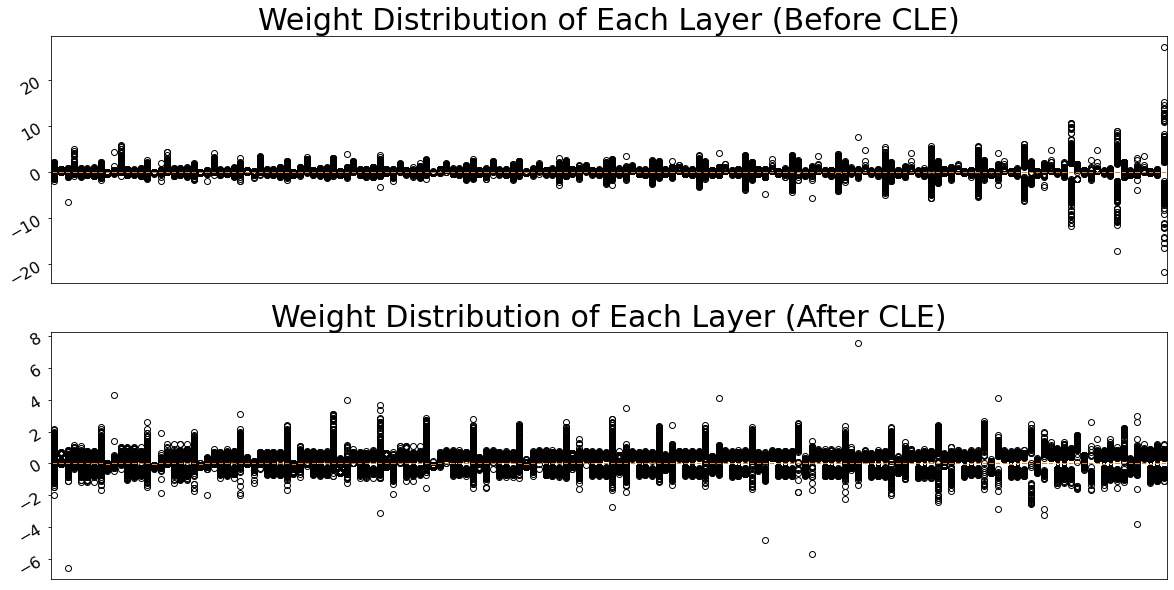

In [4]:
model = resmlp_24(pretrained=True).eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))

layer_dist(model, 0, 23, name='Weight Distribution of Each Layer (Before CLE)', ax=ax[0])
cle_for_resmlp(model)
# res_cle_for_resmlp(model)
# cle_for_resmlp(model)
layer_dist(model, 0, 23, name='Weight Distribution of Each Layer (After CLE)', ax=ax[1])
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

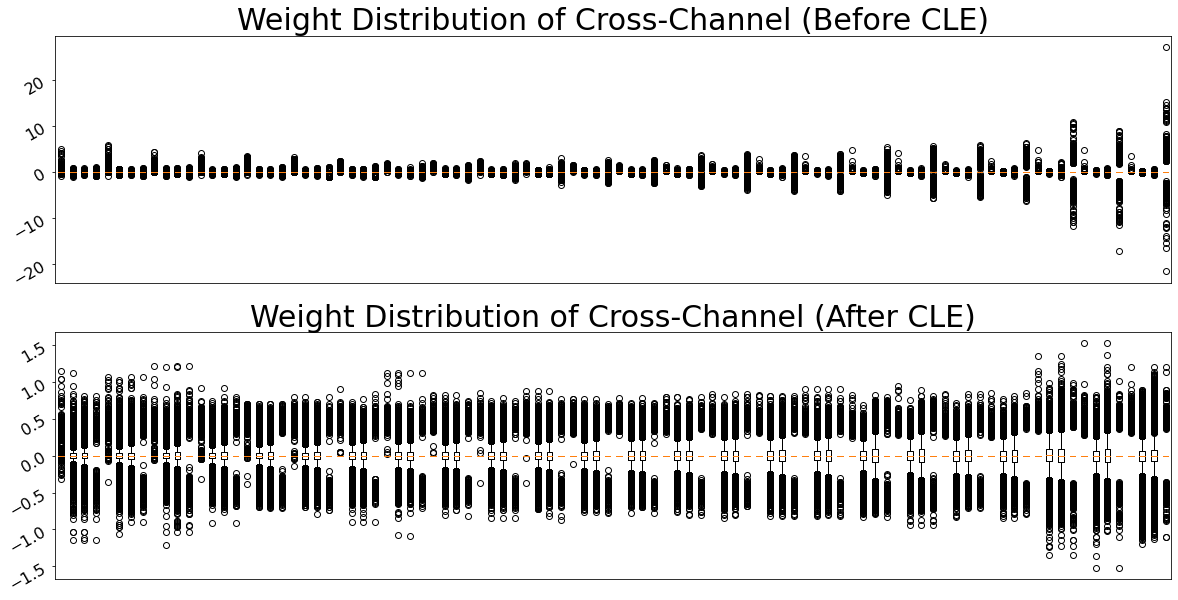

In [5]:
model = resmlp_24(pretrained=True).eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

layer_dist(model, 0, 23, show_layers=["norm2", "mlp.fc1", "mlp.fc2", "gamma_2"], name='Weight Distribution of Cross-Channel (Before CLE)', ax=ax[0])
cle_for_resmlp(model)
layer_dist(model, 0, 23, show_layers=["norm2", "mlp.fc1", "mlp.fc2", "gamma_2"], name='Weight Distribution of Cross-Channel (After CLE)', ax=ax[1])


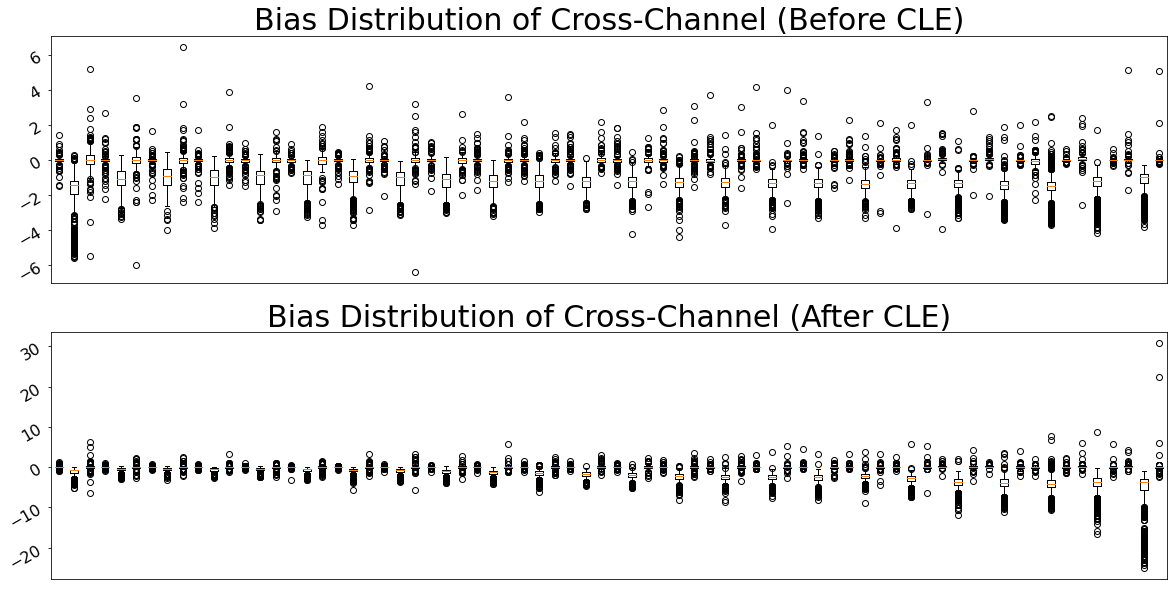

In [39]:
model = resmlp_24(pretrained=True).eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
layer_dist(model, 0, 23, show_layers=["norm2", "mlp.fc1", "mlp.fc2"], type="bias", name='Bias Distribution of Cross-Channel (Before CLE)', ax=ax[0])
cle_for_resmlp(model)
layer_dist(model, 0, 23, show_layers=["norm2", "mlp.fc1", "mlp.fc2"], type="bias", name='Bias Distribution of Cross-Channel (After CLE)', ax=ax[1])
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

In [41]:
# model = resmlp_24(pretrained=True).eval()
# fig, ax = plt.subplots(2,1, figsize=(20, 10))
# cle_for_resmlp(model)
# layer_dist(model, 0, 23, show_layers=["gamma_1", "gamma_2"], name='Weight Distribution of Skip-connect Layers (gamma_1/gamma_2)', ax=ax[0])
# layer_dist(model, 0, 23, show_layers=["norm1", "norm2"], name='Weight Distribution of Skip-connect Layers (norm1/norm2)', ax=ax[1])
# ax[0].get_xaxis().set_visible(False)
# ax[1].get_xaxis().set_visible(False)

### Activation Distribution Test

In [26]:
def create_act_hook(to_dict):
  def rec_act_name(name):
    def hook(model, input, output):
        to_dict[name] = output.detach().numpy().flatten()
    return hook
  return rec_act_name

class HookHandler():
  def __init__(self):
    self.handlers = []
  
  def apply_hook(self, hook_func, model_layers):
    for layer in model_layers:
      for n, m in layer:
        self.handlers.append( m.register_forward_hook(hook_func(n)) )
  
  def remove_hook(self):
    for handle in self.handlers:
      handle.remove()
    self.handlers = []

In [33]:
def my_boxplot(data, labels, name, ax):
  if ax is None:
    fig, ax = plt.subplots(1,1, figsize=(20, 5))
    
  ax.boxplot(data, labels=labels)
  ax.set_title(name, size=30)
  ax.tick_params(labelrotation=30)
  for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)

def act_dist(model, start, end, show_layers=None, name="Activation Distribution from Gamma_1/Gamma_2 for Each Layer", ax=None):
  model_layers = []
  for i in range(start, end+1):
      todo_layer = model.blocks[i]
      model_layers.append(get_linear_layers(todo_layer, specify_names=show_layers, prefix=f"{i}-"))

  activations = {}
  hook_handler = HookHandler()
  hook_handler.apply_hook(create_act_hook(to_dict=activations), model_layers)
  model(simulate_input())
  hook_handler.remove_hook()
  
  data = []
  labels = []
  for layer in model_layers:
    for n, m in layer:
      data.append(activations[n])
      labels.append(n)
  
  my_boxplot(data, labels, name, ax)

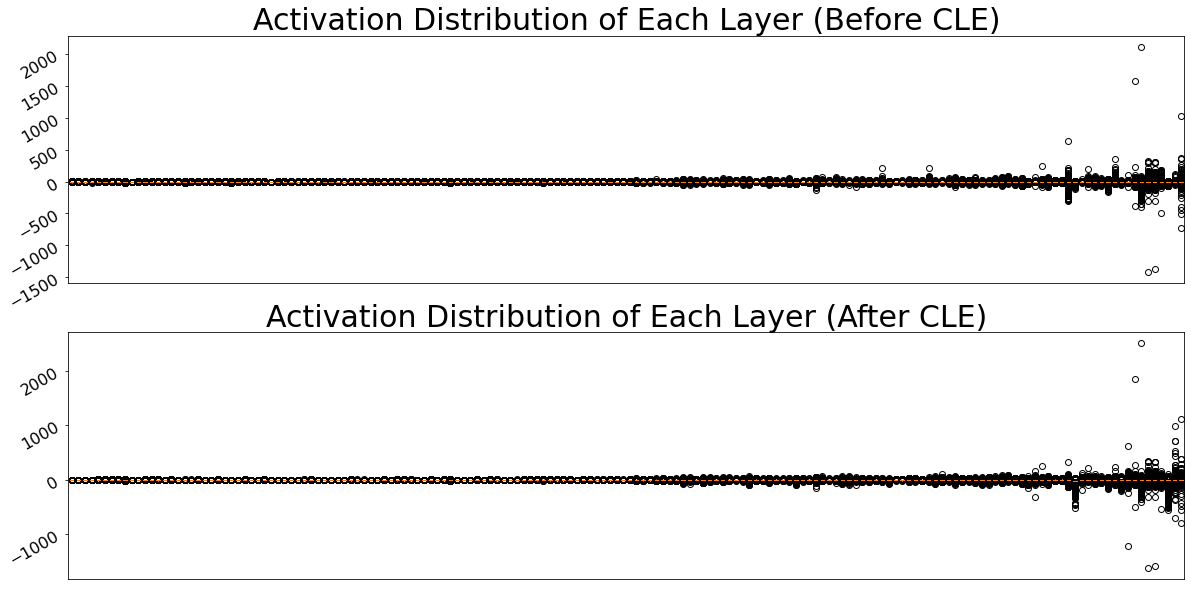

In [29]:
model = resmlp_24(pretrained=True).eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
act_dist(model, 0, 23, show_layers=all_layers, name='Activation Distribution of Each Layer (Before CLE)', ax=ax[0])
cle_for_resmlp(model)
act_dist(model, 0, 23, show_layers=all_layers, name='Activation Distribution of Each Layer (After CLE)', ax=ax[1])
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

In [ ]:
plt.title('Activation Distribution from Gamma_1/Gamma_2 for Each Layer')
plt.rcParams["figure.figsize"] = [5, 5]
plt.rcParams["figure.autolayout"] = True

data = []
labels = []

from_layers=23
to_layers=23
for name in list(activations)[from_layers*2 : (to_layers+1)*2+1]:
  labels.append(name)
  # print(activations[name].shape)
  data.append(activations[name][0].flatten())
  
# Creating plot
bp = plt.boxplot(data, labels=labels)
plt.show()

### QAT weight comparison test

In [19]:
for a in model.named_modules():
  print(a)

('', resmlp_models(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): layers_scale_mlp_blocks(
      (norm1): Linear(in_features=384, out_features=384, bias=True)
      (attn): Linear(in_features=196, out_features=196, bias=True)
      (gamma_1): Linear(in_features=384, out_features=384, bias=False)
      (drop_path): Identity()
      (skip_add): FloatFunctional(
        (activation_post_process): Identity()
      )
      (norm2): Linear(in_features=384, out_features=384, bias=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): ReLU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (gamma_2): Linear(in_features=384, out_features=384, bias=False)
    )
    (1): layers_scale_mlp_blocks(
      (norm1): L

In [ ]:
import torch.nn as nn
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.my_tensor = torch.zeros(1) # 参数直接作为模型类成员变量
    self.register_buffer('my_buffer', torch.zeros(1)) # 参数注册为 buffer
    self.my_param = nn.Parameter(torch.zeros(1), requires_grad=False)

  def forward(self):
    self.my_tensor = torch.ones(1)
    self.my_param = nn.Parameter(torch.ones(1), requires_grad=False)
    self.my_buffer = torch.ones(1)
    return

model = MyModel()
model()

print(model.state_dict())
model.cuda()
print(model.state_dict())

In [ ]:
checkpoint = torch.load("model_best.pth.tar")['state_dict']
# print(checkpoint)
modified_dict = {}
for key, value in checkpoint.items():
    if 'num_batches_tracked' in key: continue
    # if 'weight_integer' in key: continue
    # if 'bias_integer' in key: continue

    modified_key = key.replace("module.", "")
    modified_dict[modified_key] = value
qmodel.load_state_dict(modified_dict, strict=True)

In [ ]:
org_model = resmlp_24(pretrained=True)
org_qmodel = q_resmlp24(org_model, full_precision_flag=True)

torch.equal(qmodel.layer0.gamma_1.linear.weight, org_qmodel.layer0.gamma_1.linear.weight)